This is a compiled notebook for alignment of coronal brain slices via STalign (followed up by VisuAlign manual adjustement) and subsequent region boundary export

Tags:
- "REPLACE ME": places for user to input their own files (required)
- "CHANGE ME": places where user can modify behavior (optional)

In [4]:
#Import dependencies

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pdcm
import IPython
import os
from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
import nrrd
import torch
from torch.nn.functional import grid_sample
import shutil
import skimage as ski
import STalign
import nibabel as nib
from scipy.ndimage import rotate
import shapely
from sklearn.cluster import dbscan
import json
%matplotlib tk

Loading in resources, target images, etc

Target Image #1 has shape (936, 1005)
Target Image #2 has shape (839, 949)
Target Image #3 has shape (1054, 1255)


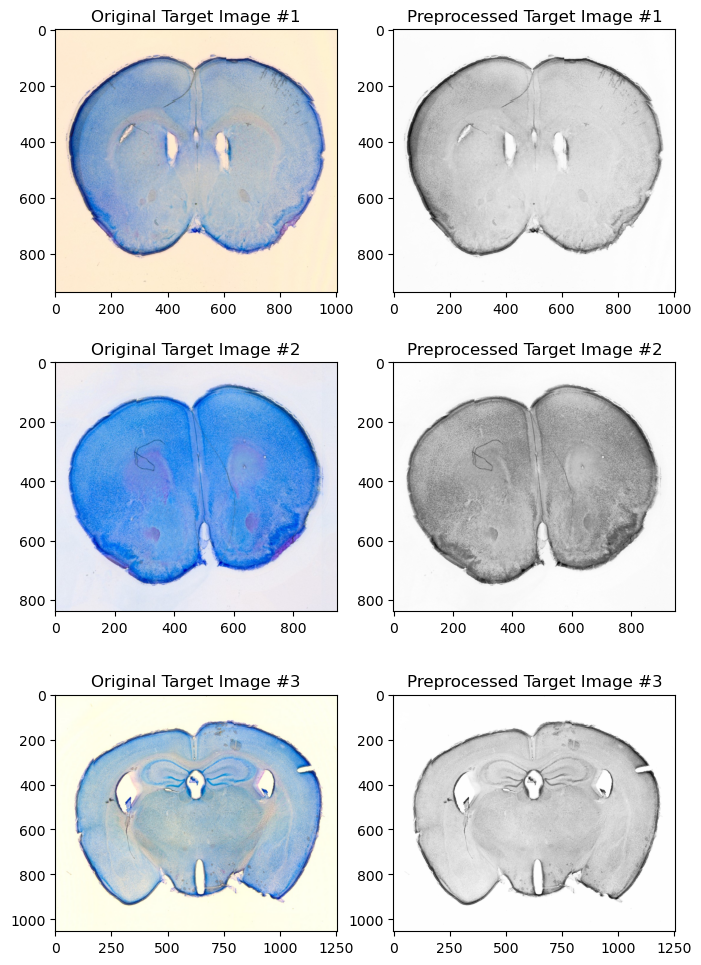

In [5]:
# Loading in target image
%matplotlib inline

data_folder = "Data\\Target_samples\\batch 2" #### REPLACE ME #### path to folder with images
target_filenames = os.listdir(data_folder)
targets_original = []
targets_ds = []
targets = []

for img_filename in target_filenames:
    W_original = ski.io.imread(join(data_folder,img_filename))
    W = W_original.copy()

    # uncomment/comment out preprocessing lines as needed, feel free to edit, rearrange, and add your own pre-processing
    ds_factor = 1 #### CHANGE ME #### if working with larger image that needs downscaling
    W = ski.transform.downscale_local_mean(W, (ds_factor, ds_factor,1)) # downscaling using above factor
    W_ds = W.copy().astype('uint8') # save downscaled but not gray scaled image
    W = ski.color.rgb2gray(W) # greyscaling rgb image
    W = (W - np.min(W)) / (np.max(W) - np.min(W)) # normalizing image
    W = 1-W # inverting, optional #### CHANGE ME #### comment/uncomment as needed to ensure image looks good

    targets_original.append(W_original)
    targets_ds.append(W_ds)
    targets.append(W)
    print(f'Target Image #{len(targets)} has shape {W.shape}')

fig, ax = plt.subplots(len(targets),2,figsize=(8,4*len(targets)))
for i in range(len(targets)):
    if len(targets) == 1: ax = [ax]
    ax[i][0].imshow(targets_original[i])
    ax[i][0].set_title(f"Original Target Image #{i+1}")
    ax[i][1].imshow(targets[i],cmap='Grays')
    ax[i][1].set_title(f"Preprocessed Target Image #{i+1}")


In [6]:
# Loading Atlas
# options: DAPI, ALLEN, OTHER 
# RECOMMENDED: DAPI stained Atlas - https://www.nature.com/articles/s41597-020-0570-z
# we use this one because the slices were cryosectioned, stained, and dried on a slide
# which is similar to the protocl used in our lab for the experiment this tool was designed for
# HOWEVER you can also use the allen atlas if that fits your purposes better, OR you can upload
# your own atlas to align to
# if you want to use DAPI atlas, keep <chosen_atlas> = 'DAPI',
# if you want to use Allen atlas, set <chosen_atlas> = 'ALLEN',
# if you want to use another atlas of your choice, set <chosen_atlas> = 'OTHER' AND 
# fill in your own code for uploading the atlas

chosen_atlas = 'DAPI' #### CHANGE ME ####

if chosen_atlas == 'DAPI':

    reference_img = nib.load("Data\\Atlases\\DAPI\\img_dapi.nii").get_fdata()
    reference_labels = nib.load("Data\\Atlases\\DAPI\\label_dapi.nii").get_fdata()

    A_original = np.flip(np.transpose(reference_img,(1,2,0)),axis=(0,1))
    S = np.flip(np.transpose(reference_labels,(1,2,0)),axis=(0,1))


    # downsize for faster stalign then normalize
    atlas_ds_factor = (1,4,4) #### CHANGE ME ####
    A = ski.transform.downscale_local_mean(A_original, atlas_ds_factor)  
    A = np.clip(A, 0, A.max()) # clipping negative values to 0
    A = (A - np.min(A)) / (np.max(A) - np.min(A)) # normalize

    dxS = [33.34,8.6,8.6] # set pixel dims
    dxA = np.multiply(dxS, atlas_ds_factor)
    nxA = A.shape

    dimAtlas = A.shape
    print("DAPI Atlas loaded successfully")

elif chosen_atlas == 'ALLEN':

    A,_ = nrrd.read("Data\\Atlases\\Allen_50\\img_allen_50.nrrd")
    S, hdr = nrrd.read('Data\\Atlases\\Allen_50\\label_allen_50.nrrd')
    S = np.array(S,dtype='float64')

    A = np.array((A - np.min(A)) / (np.max(A) - np.min(A)),dtype='float64') # normalize

    dxA = np.diag(hdr['space directions']) # set pixel dims
    dxS = dxA
    nxA = A.shape # set dimensions of image

    dimAtlas = A.shape
    print("Allen Atlas loaded successfully")

elif chosen_atlas == 'OTHER':
    #### CUSTOM ATLAS UPLOAD ####
    # must load reference atlas data as A
    # must load labels/segmentation as S
    # must set nxA, the dimensions of A
    # must set dxA and dxS, the dimensions of each pixel in the reference and labels atlas
    # the values of dxA and dxS must correspond to the dimensions of the pixels in the directions that match nxA
    # example: if nxA provides dimensions in [anterior-posterior,superior-inferior,left-right], then dxA and dxS must also provide pixel dimensions in the same order
    pass #### CHANGE ME ####


else: print("PLEASE SET <chosen_atlas> to 'DAPI', 'ALLEN', or 'OTHER' ")

xA = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxA,dxA)]
XA = np.meshgrid(*xA,indexing='ij')

DAPI Atlas loaded successfully


Initial Affine Estimation

In [7]:
# Get Slice and Rotations #
%matplotlib tk
from IPython.display import clear_output

# poitns stored in z,y,x format
deg2rad = lambda deg: np.pi*deg/180
rad2deg = lambda rad: 180*rad/np.pi

# rotation matrices for along z-axis, y-axis, and x-axis
def z_rot(deg):
    rads = deg2rad(deg)
    return np.array([
                        [1,       0       ,         0      ],
                        [0, np.cos(rads), -np.sin(rads)],
                        [0, np.sin(rads), np.cos(rads) ]
                    ])

def y_rot(deg):
    rads = deg2rad(deg)
    return np.array([
                        [ np.cos(rads), 0, np.sin(rads)],
                        [        0      , 1,     0         ],
                        [-np.sin(rads), 0, np.cos(rads)]
                    ])

def x_rot(deg):
    rads = deg2rad(deg)
    return np.array([
                        [np.cos(rads), -np.sin(rads), 0],
                        [np.sin(rads),  np.cos(rads), 0],
                        [       0      ,        0       , 1]
                    ])

# get an affine matrix for a given set of rotations
def get_L(thetas):
    # thetas follows [z,y,x] format where 'z' represents rotations about the z axis
    L_estim = np.array([[1,0,0],
                        [0,1,0],
                        [0,0,1]])
                        
    L_estim = L_estim@x_rot(thetas[2])
    L_estim = L_estim@y_rot(thetas[1])
    L_estim = L_estim@z_rot(thetas[0])
    return(L_estim)

# output msgs cleanly
def msg(msg):
    clear_output()
    print(msg)


# setting 
if 'T_estim' not in locals(): # keep translation from previous runs
    T_estim = np.array([[0, 0, 0] for i in targets])

if 'thetas' not in locals(): #avoid wiping out thetas from  previous runs
    thetas = np.array([[0,0,0] for i in targets]) # z, y, x order
alpha = 1.25 # factor to expand meshgrid dimensions by to allow for rotation
xE = [alpha*x for x in xA]
XE = np.stack(np.meshgrid(np.zeros(1),xE[1],xE[2],indexing='ij'),-1)

nS = S.shape
xS = [np.arange(n)*d - (n-1)*d/2  for n,d in zip(nS, dxS)]

## Handle showing atlas ##
slice_from_T = lambda T: T/dxA[0] + A.shape[0]/2
T_from_slice = lambda slice: dxA[0]*(slice - A.shape[0]/2)
def atlas_img(thetas,T):
    slice_t = (get_L(thetas) @ XE[...,None])[...,0] + T
    img = STalign.interp3D(xA, A[None].astype('float64'), 
                           slice_t.transpose(3,0,1,2))[0,0,...]
    #if chosen_atlas == 'ALLEN': return 1-img.numpy()
    return img.numpy()

def seg_img(thetas, T):
    slice_t = (get_L(thetas)@XE[...,None])[...,0] + T
    img = STalign.interp3D(xS, S[None].astype('float64'), 
                           slice_t.transpose(3,0,1,2), 
                           mode='nearest')[0,0,...]
    return img.numpy()

## Event Handling ##

class Affine_estimator:

    def __init__(self):

        # creating figures
        self.fig, self.ax = plt.subplots(1,2)
        self.fig.subplots_adjust(left=0.2)
        self.index = 0
        self.show_atlas()
        self.show_target()

        # adding prev and next button
        ax_prev = self.fig.add_axes([0.7,0.05,0.1,0.1])
        ax_next = self.fig.add_axes([0.8,0.05,0.1,0.1])
        self.prev_btn = mpl.widgets.Button(ax_prev, label='Previous')
        self.next_btn = mpl.widgets.Button(ax_next, label='Next')
        self.prev_btn.on_clicked(self.on_prev)
        self.next_btn.on_clicked(self.on_next)

        # adding sliders for rotation
        ax_x = self.fig.add_axes([0.05,0.2,0.03,0.7])
        ax_y = self.fig.add_axes([0.1,0.2,0.03,0.7])
        ax_z = self.fig.add_axes([0.15,0.2,0.03,0.7])
        self.degrees_x = mpl.widgets.Slider(ax_x,'x', valmin=-90, valmax=90, valinit=0, valstep=1, orientation='vertical')
        self.degrees_y = mpl.widgets.Slider(ax_y,'y', valmin=-90, valmax=90, valinit=0, valstep=1, orientation='vertical')
        self.degrees_z = mpl.widgets.Slider(ax_z,'z', valmin=-180, valmax=180, valinit=0, valstep=1, orientation='vertical')
        self.degrees_x.on_changed(self.rot_x)
        self.degrees_y.on_changed(self.rot_y)
        self.degrees_z.on_changed(self.rot_z)

        # adding slider for translation
        ax_t = self.fig.add_axes([0.2, 0.05, 0.4, 0.03])
        self.translation = mpl.widgets.Slider(ax_t, 'slice  ', valmin=0, valmax=A.shape[0], valinit=A.shape[0]//2)
        self.translation.on_changed(self.translate)

        self.set_sliders()

        self.fig.canvas.mpl_connect('key_press_event', self.on_press)

    def on_press(self, event):
        if event.key=='backspace': 
            thetas[self.index] = np.array([0,0,0])
            T_estim[self.index,0] = 0
            self.show_atlas()
            self.set_sliders()

    def translate(self, slice):
        T_estim[self.index,0] = T_from_slice(slice)
        self.show_atlas()
    
    def rot_x(self, angle):
        thetas[self.index,2] = angle
        self.show_atlas()

    def rot_y(self, angle):
        thetas[self.index,1] = angle
        self.show_atlas()

    def rot_z(self, angle):
        thetas[self.index,0] = angle
        self.show_atlas()

    def show_target(self):
        img = targets[self.index]
        self.ax[1].clear()
        self.ax[1].imshow(img,cmap='Grays')
        self.ax[1].set_title(f'Target img #{self.index+1}')
        self.ax[1].set_axis_off()
        plt.draw()

    def show_atlas(self):
        img = atlas_img(thetas[self.index],T_estim[self.index])
        self.ax[0].cla()
        self.ax[0].imshow(img, cmap='Grays')
        self.ax[0].set_title(f'Atlas Slice {int(slice_from_T(T_estim[self.index,0]))}/{len(A)}')
        self.ax[0].set_axis_off()
        plt.draw()

    def set_sliders(self):
        self.degrees_x.set_val(thetas[self.index,2])
        self.degrees_y.set_val(thetas[self.index,1])
        self.degrees_z.set_val(thetas[self.index,0])
        self.translation.set_val(slice_from_T(T_estim[self.index,0]))

    def on_prev(self,event):
        self.index -= 1
        self.index %= len(targets)
        self.show_target()
        self.show_atlas()
        self.set_sliders()

    def on_next(self,event):
        self.index += 1
        self.index %= len(targets)
        self.show_target()
        self.show_atlas()
        self.set_sliders()

######################### CONTROLS ########################
# scroll up/down: incr/decr slice                         #
# arrow left/right: rot y-axis cw/ccw (top-down view)     #
# arrow up/down: rot x-axis cw/ccw (right side view)      #
# mouse click left/right: rot z-axis ccw/cw (frontal vew) #
###########################################################

# show atlas and target image
interface = Affine_estimator()

In [8]:
# Get images of estimated slice to use in future steps
# WARNING: this cell may take up to 1 minute to run, if it takes a while to run, DO NOT STOP IT, let it run its course
L_estim = np.array([get_L(theta) for theta in thetas])
slice_imgs = [atlas_img(theta,T) for theta,T in zip(thetas, T_estim)]
slice_labels = [seg_img(theta,T) for theta,T in zip(thetas, T_estim)]
bounds = [ski.segmentation.find_boundaries(sl) for sl in slice_labels]
slice_segs = [ski.segmentation.mark_boundaries(si, sl.astype('int'),color=(0,0,255),mode='inner') for si,sl in zip(slice_imgs, slice_labels)]

print(f"ESTIMATED AFFINE (L)\n{L_estim}\nRotation along z,y,x axes respectively:{thetas}\nTranslation along z,y,x axes respectively (um):{T_estim}:")

ESTIMATED AFFINE (L)
[[[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]]
Rotation along z,y,x axes respectively:[[0 0 0]
 [0 0 0]
 [0 0 0]]
Translation along z,y,x axes respectively (um):[[0 0 0]
 [0 0 0]
 [0 0 0]]:


Estimating the voxel dimensions of the target image

In [ ]:
# If you know the pixel dimensions of your image, you can add them here, if not, leave it at 0
# The first element should be the length of each pixel in the superior-inferior direction
# The second element should be the length of each pixel in the left-right direction
%matplotlib tk
pixdim = [0,0] #### CHANGE ME #### format should be [height (um), width (um)]
dxW = pixdim*ds_factor #### CHANGE ME ####
estimate_dxW = (np.prod(dxW)==0) # if true, need to estimate, else no need to estimate

# this lambda function returns the contour for a given image, given a specific threshold
def contour (img, threshold):
    contours = ski.measure.find_contours(img, threshold)
    return sorted(contours, key=lambda c: shapely.Polygon(c).area)[-1]

if estimate_dxW:
    # you'll have to play with this number to achieve a good contour of your target image
    contour_threshold = .1 #### CHANGE ME #### (between 0-1)
    sample_img_index = 0 #### CHANGE ME #### choose a different one of the target images if it's hard to find a contour for this
    cA = contour(slice_imgs[sample_img_index], 0.1)
    cT = contour(targets[sample_img_index], contour_threshold)

    # we use this contour to estimate the scale of your image with respect to the atlas,
    # which allows us to estimate the dimensions
    area_A = shapely.Polygon(cA).area
    area_T = shapely.Polygon(cT).area
    
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(slice_imgs[sample_img_index], cmap='Grays')
    ax[1].imshow(targets[sample_img_index], cmap='Grays')

    ax[0].plot(cA[:,1], cA[:,0],c='r')
    ax[1].plot(cT[:,1], cT[:,0],c='r')

    # scale based on ratio of areas
    scale = np.sqrt(area_T / area_A) / alpha # must also correct for expansion of atlas dimensions from alpha
    print(f'Scale: {scale}')
    dxW = (1/scale)*dxA[1:]
    print(f'Estimated pixel dimensions of target images: {dxW}')

xJs = [[np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(W.shape,dxW)] for W in targets]
Js = [W[None]/np.mean(np.abs(W)) for W in targets]
xI = xA
I = A[None] / np.mean(np.abs(A),keepdims=True)
I = np.concatenate((I,(I-np.mean(I))**2)) # comment this line out when using stalign_no_contrast

Scale: 3.7913907301131857
Estimated pixel dimensions of target images: [9.07318777 9.07318777]


Annotating Landmark Points

In [ ]:
### POINT ANNOTATOR ###
# left side is atlas slice
# right side is target image
# use mouse left click to mark a pair of corresponding points on atlas and target
# right click removes the point
# enter commits points to list
# backspace removes most recently committed point
# ctrl+backspace clears all points
# COLOR KEY
# red: new marked point, not committed
# orange: most recently committed point, will be removed with backspace
# black: committed point
# when done selecting and committing points, simply move on to next cell
%matplotlib tk
if 'points' not in locals(): # avoid wiping out points from previous runs of this cell
    points = [[[],[]] for t in targets]

extentAtlasSlice = STalign.extent_from_x(xE[1:])
extents_target = [STalign.extent_from_x(xJ) for xJ in xJs]
new_pts = [[[],[]] for t in targets]

class Point_Annotator:
    
    def __init__(self):
        self.index = 0
        self.pt_sz = 4
        self.show_seg = False

        self.fig, self.ax = plt.subplots(1,2)
        self.fig.subplots_adjust(left=0.2)
        self.show_atlas()
        self.show_target()

        # adding prev and next button
        ax_prev = self.fig.add_axes([0.7,0.05,0.1,0.1])
        ax_next = self.fig.add_axes([0.8,0.05,0.1,0.1])
        self.prev_btn = mpl.widgets.Button(ax_prev, label='Previous')
        self.next_btn = mpl.widgets.Button(ax_next, label='Next')
        self.prev_btn.on_clicked(self.on_prev)
        self.next_btn.on_clicked(self.on_next)

        self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        self.fig.canvas.mpl_connect('key_press_event', self.on_press)

    def show_target(self):
        img = targets[self.index]
        self.ax[1].clear()
        self.ax[1].set_title(f'Target img #{self.index+1}')
        self.ax[1].imshow(img,cmap='Grays', extent=extents_target[self.index])
        if len(points[self.index][1]):
            self.ax[1].scatter(np.array(points[self.index])[1,:, 1], np.array(points[self.index])[1,:, 0], color='lime', s=self.pt_sz)
            self.ax[1].scatter(np.array(points[self.index])[1,-1, 1], np.array(points[self.index])[1,-1, 0], color='orange', s=self.pt_sz)
        if len(new_pts[self.index][1]):
            self.ax[1].scatter(new_pts[self.index][1][1], new_pts[self.index][1][0], color='red', s=self.pt_sz)
        plt.draw()

    def show_atlas(self):
        if self.show_seg: img = slice_segs[self.index]
        else: img = slice_imgs[self.index]
        self.ax[0].clear()
        self.ax[0].set_title(f'Atlas Slice {int(slice_from_T(T_estim[self.index,0]))}/{len(A)}')
        self.ax[0].imshow(img, cmap='Grays', extent=extentAtlasSlice)
        if len(points[self.index][0]):
            self.ax[0].scatter(np.array(points[self.index])[0,:, 1], np.array(points[self.index])[0,:, 0], color='lime', s=self.pt_sz)
            self.ax[0].scatter(np.array(points[self.index])[0,-1, 1], np.array(points[self.index])[0,-1, 0], color='orange', s=self.pt_sz)
        if len(new_pts[self.index][0]):
            self.ax[0].scatter(new_pts[self.index][0][1], new_pts[self.index][0][0], color='red', s=self.pt_sz)
        plt.draw()

    def on_prev(self,event):
        self.index -= 1
        self.index %= len(targets)
        self.show_target()
        self.show_atlas()

    def on_next(self,event):
        self.index += 1
        self.index %= len(targets)
        self.show_target()
        self.show_atlas()

    def onclick(self, event):

        if event.button == 2: 
            self.show_seg = not self.show_seg
            msg("Toggled segmentation")
            self.show_atlas()
            return
            
        if event.xdata == None: return # clicked outside of plot
        ix, iy = int(event.xdata), int(event.ydata) # get x and y data of pt
        message = f'[{ix}, {iy}]'
        
        axis = -1
        # based on where user clicked, set axis and update output message
        if event.inaxes == self.ax[0]:
            axis = 0
            message = "source at " + message
        elif event.inaxes == self.ax[1]:
            axis = 1
            message = "target at " + message
        else: return

        if event.button == 1: # left click means add point at mouse location
            new_pts[self.index][axis] = [iy, ix]
            message = 'point added to ' + message
        elif event.button == 3: # right click means remove previously created point
            new_pts[self.index][axis] = []
            message = 'point removed from ' + message

        msg(message)
        # refresh that axis to clear out any previously clicked on pts that were not committed
        if axis == 0: self.show_atlas() # refresh atlas
        if axis == 1: self.show_target() # refresh target


    def on_press(self, event):
        if event.key == 'enter': # enter key used to commit selected points to points list

            if not len(new_pts[self.index][0])*len(new_pts[self.index][1]): # if missing a point in either axis, throw error
                print("ERROR: attempted landmark save with one or more points missing!")
                return

            # add new points to list, notify user, and clear out new points list
            points[self.index][0].append(new_pts[self.index][0])
            points[self.index][1].append(new_pts[self.index][1])
            msg(f"Added [{new_pts[self.index][0]}] and [{new_pts[self.index][1]}] to points list.\n{len(points[self.index][0])} marked points")
            new_pts[self.index][0] = []
            new_pts[self.index][1] = []
            
            # refresh both axes
            self.show_atlas() 
            self.show_target()

        elif event.key == 'backspace': # backspace key used to remove recently committed point
            if len(points[self.index][0]) == 0: return # if no points to remove, simply return
            msg(f'Removed [{points[self.index][0][-1]}] and [{points[self.index][1][-1]}]\n{len(points[self.index][0])-1} marked points') # user msg
            
            # remove last pair of poins
            points[self.index][0].pop(-1)
            points[self.index][1].pop(-1)
            
            # refresh both axes
            self.show_atlas() 
            self.show_target()
            
        elif event.key == 'ctrl+backspace': #ctr+backspace to remove all poins
            if len(points[self.index][0]) == 0: return # if no points to remove, simply return
            msg('Removed all points')
            points[self.index][0] = []
            points[self.index][1] = []
            new_pts[self.index][0] = []
            new_pts[self.index][1] = []
            
            self.show_atlas() 
            self.show_target()

# output msgs cleanly
def msg(msg):
    clear_output()
    print(msg)


interface = Point_Annotator()

In [ ]:
### PROCESSING POINTS ###
%matplotlib inline
points_np = [np.array(s) for s in points]
slice_pts = [(get_L(thetas[index])@XE[...,None])[...,0] + T_estim[index] for index in range(len(targets))]
x_to_pix = lambda x: (x-xE[2][0])/alpha/dxA[2]
y_to_pix = lambda y: (y-xE[1][0])/alpha/dxA[1]

pts_atlas_pix = [np.array([[y_to_pix(px[0]), x_to_pix(px[1])] for px in points[index][0]]).astype(int) for index in range(len(targets))] # get pixel locations of points on atlas
points_atlas = [slice_pts[index][0, pts[:,0], pts[:,1]] if points_np[index].shape[1] else None for index, pts in enumerate(pts_atlas_pix)] # convert that to points pointed to by sampling array (slice_pts)
points_target = [np.insert(points_np[index][1],0,0,axis=1) if points_np[index].shape[1] else None for index in range(len(targets))]

# plot points to confirm
fig, ax = plt.subplots(len(targets),2, figsize=(10,4*len(targets)))
fig.subplots_adjust(hspace=0.1, wspace=0.2)
for i in range(len(targets)):
    if len(targets) == 1: ax = [ax]
    ax[i][0].imshow(slice_imgs[i], extent=extentAtlasSlice, cmap='Grays')
    ax[i][1].imshow(targets[i], extent=extents_target[i], cmap='Grays')

    if points_np[i].shape[1]:
        ax[i][0].scatter(points_np[i][0,:,1], points_np[i][0,:,0], color='red', s=5)
        ax[i][1].scatter(points_np[i][1,:,1], points_np[i][1,:,0], color='red', s=5)

Running STalign

In [ ]:
#### SETTING PARAMETERS FOR STALIGN ####
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

scale_x = 1
scale_y = 1
scale_z = 1

Ls = np.array([np.linalg.inv(Li) for Li in L_estim])
Ts = -T_estim
scale_atlas = np.array([[scale_z,0,0],
                        [0,scale_y,0],
                        [0,0,scale_x]])
Ls = np.matmul(Ls,scale_atlas)

#### CHANGE ME ####
# Adjust default settings for hyperparameters here
default_nt = 12 # number of time steps, increase for smoother transform at expense of time
default_niter = 100 # number of gradient descent iterations suggested: 100, 'gold standard' is 2000 but takes 1hr to run
default_sigmaM = .5 # matching error -> increase to de-emphasize it# matching error -> increase to de-emphasize it
default_sigmaP = 1 # points error -> increase to de-emphasize it
default_sigmaR = 1e8 # regularization error -> increase to de-emphasize it
default_a = 250 # resolution of alignment -> increase to speed up alignment at expense of fine alignment, decrease to improve fine alignment at expense of time
####################

# creating an array for each hyperparameter for each slice
nts = [default_nt for i in range(len(targets))]
nts = [default_nt for i in range(len(targets))]
niters = [default_niter for i in range(len(targets))]
sigmaMs = [default_sigmaM for i in range(len(targets))]
sigmaPs = [default_sigmaP for i in range(len(targets))]
sigmaRs = [default_sigmaR for i in range(len(targets))]
a_s = [default_a for i in range(len(targets))]

###### Adjust individual values here ######
# For example, to adjust the sigmaM of the 5th slice to 10,
# sigmaMs[4] = 10




In [ ]:
### FUNCTION DEFINITIONS ###

# for LDDMM_LBGFS
def LDDMM_3D_LBGFS(xI,I,xJ,J,pointsI=None,pointsJ=None,
        L=None,T=None,A=None,v=None,xv=None,
        a=500.0,p=2.0,expand=1.25,nt=3,
        niter=5000,diffeo_start=0, epL=1e-6, epT=1e1, epV=1e3,
        sigmaM=1.0,sigmaB=2.0,sigmaA=5.0,sigmaR=1e8,sigmaP=2e1,
        device='cpu',dtype=torch.float64, muA=None, muB = None):

        
    # check initial inputs and convert to torch
    if A is not None:
        # if we specify an A
        if L is not None or T is not None:
            raise Exception('If specifying A, you must not specify L or T')
        L = torch.tensor(A[:3,:3],device=device,dtype=dtype,requires_grad=True)
        T = torch.tensor(A[:3,-1],device=device,dtype=dtype,requires_grad=True)   
    else:
        # if we do not specify A                
        if L is None: L = torch.eye(3,device=device,dtype=dtype,requires_grad=True)
        if T is None: T = torch.zeros(3,device=device,dtype=dtype,requires_grad=True)
    
    L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
    T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
    # change to torch
    I = torch.tensor(I,device=device,dtype=dtype)                         
    J = torch.tensor(J,device=device,dtype=dtype)
    if J.ndim == 3:
        J = J[:,None] # add a z slice dimension


    if v is not None and xv is not None:
        v = torch.tensor(v,device=device,dtype=dtype,requires_grad=True)
        xv = [torch.tensor(x,device=device,dtype=dtype) for x in xv]
        XV = torch.stack(torch.meshgrid(xv),-1)
        nt = v.shape[0]        
    elif v is None and xv is None:
        minv = torch.as_tensor([x[0] for x in xI],device=device,dtype=dtype)
        maxv = torch.as_tensor([x[-1] for x in xI],device=device,dtype=dtype)
        minv,maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0],device=device,dtype=dtype)[...,None]*(maxv-minv)*expand
        xv = [torch.arange(m,M,a*0.5,device=device,dtype=dtype) for m,M in zip(minv,maxv)]
        XV = torch.stack(torch.meshgrid(xv),-1)
        v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2],XV.shape[3]),device=device,dtype=dtype,requires_grad=True)
        
    else:
        raise Exception(f'If inputting an initial v, must input both xv and v')
    extentV = STalign.extent_from_x(xv[1:])
    dv = torch.as_tensor([x[1]-x[0] for x in xv],device=device,dtype=dtype)
    
    fv = [torch.arange(n,device=device,dtype=dtype)/n/d for n,d in zip(XV.shape,dv)]
    extentF = STalign.extent_from_x(fv[1:])
    FV = torch.stack(torch.meshgrid(fv),-1)
    LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0)

    K = 1.0/LL
    #fig,ax = plt.subplots()
    #ax.imshow(K,vmin=0.0,vmax=0.1,extent=extentF)
    
    #fig,ax = plt.subplots()
    #ax.imshow(K[0].cpu())
    DV = torch.prod(dv)
    Ki = torch.fft.ifftn(K).real
    fig,ax = plt.subplots()
    ax.imshow(Ki[Ki.shape[0]//2].clone().detach().cpu().numpy(),vmin=0.0,extent=extentV)
    ax.set_title('smoothing kernel')
    fig.canvas.draw()

    # initialize weights
    WM = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.5
    WB = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.4
    WA = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.1

    # locations of pixels
    extentI = STalign.extent_from_x(xI[1:]) 
    xI = [torch.tensor(x,device=device,dtype=dtype) for x in xI]
    if len(xJ) == 2:
        xJ = [[0.0],xJ[0],xJ[1]]    
    extentJ = STalign.extent_from_x(xJ[1:])
    xJ = [torch.tensor(x,device=device,dtype=dtype) for x in xJ]
    XI = torch.stack(torch.meshgrid(*xI,indexing='ij'),-1)
    XJ = torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1)
    dJ = [x[1]-x[0] for x in xJ[1:]]

    # a figure
    fig,ax = plt.subplots(2,3)
    ax = ax.ravel()
    if type(pointsI) != type(None): figE,axE = plt.subplots(1,4)
    else: figE,axE = plt.subplots(1,3)
    axE = axE.ravel()
    Esave = []
    # zero gradients
    try:
        L.grad.zero_()
    except:
        pass
    try:
        T.grad.zero_()
    except:
        pass

    if pointsI is None and pointsJ is None:
        pointsI = torch.zeros((0,2),device=J.device,dtype=J.dtype)
        pointsJ = torch.zeros((0,2),device=J.device,dtype=J.dtype)
    elif (pointsI is None and pointsJ is not None) or (pointsJ is None and pointsI is not None):
        raise Exception('Must specify corresponding sets of points or none at all')
    else:
        pointsI = torch.tensor(pointsI,device=J.device,dtype=J.dtype)
        pointsJ = torch.tensor(pointsJ,device=J.device,dtype=J.dtype)

    optimizer = torch.optim.Adam([L, T,v], lr=1e-3)#, max_iter=4, line_search_fn="strong_wolfe")
    def closure():
        optimizer.zero_grad()
        
        A = STalign.to_A_3D(L,T)

        # Ai
        Ai = torch.linalg.inv(A)
        # transform sample points        
        Xs = (Ai[:-1,:-1]@XJ[...,None])[...,0] + Ai[:-1,-1]
        
        # now diffeo, not semilagrange here
        for t in range(nt-1,-1,-1):
            Xs = Xs + STalign.interp3D(xv,-v[t].permute(3,0,1,2),Xs.permute(3,0,1,2)).permute(1,2,3,0)/nt
        
        # and points
        pointsIt = torch.clone(pointsI)
        if pointsIt.shape[0] >0:
            for t in range(nt):
                pointsIt += (STalign.interp3D(xv,v[t].permute(3,0,1,2),pointsIt.T[...,None,None])[...,0,0].T/nt)
            pointsIt = (A[:-1,:-1]@pointsIt.T + A[:-1,-1][...,None]).T 
       
        # transform image
        AI = STalign.interp3D(xI,I,Xs.permute(3,0,1,2),padding_mode="border")

        fAI = AI
        # objective function
        EM = torch.sum((fAI - J)**2*WM)/2.0/sigmaM**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
            
        E = EM + ER
        
        if pointsIt.shape[0]>0:
            EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
            E += EP

        E.backward(retain_graph=True)
        return E
    
    for it in range(niter):
        print(f'Iteration #{it}:')

        torch.autograd.set_detect_anomaly(True)
        optimizer.zero_grad()        
        # make A
        A = STalign.to_A_3D(L,T)

        # Ai
        Ai = torch.linalg.inv(A)
        # transform sample points        
        Xs = (Ai[:-1,:-1]@XJ[...,None])[...,0] + Ai[:-1,-1]
        # now diffeo, not semilagrange here
        for t in range(nt-1,-1,-1):
            #print(Xs.shape)
            Xs = Xs + STalign.interp3D(xv,-v[t].permute(3,0,1,2),Xs.permute(3,0,1,2)).permute(1,2,3,0)/nt
        # # and points (not in 3D)        
        #print(np.shape(pointsI))
        
        pointsIt = torch.clone(pointsI)
        if pointsIt.shape[0] >0:
            for t in range(nt):
                pointsIt += (STalign.interp3D(xv,v[t].permute(3,0,1,2),pointsIt.T[...,None,None])[...,0,0].T/nt)
            pointsIt = (A[:-1,:-1]@pointsIt.T + A[:-1,-1][...,None]).T
        
        # transform image
        AI = STalign.interp3D(xI,I,Xs.permute(3,0,1,2),padding_mode="border")

        fAI = AI
        # objective function
        EM = torch.sum((fAI - J)**2*WM)/2.0/sigmaM**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
        #if pointsIt.shape[0]>0: EP = torch.sum((pointsIt_t - pointsJt)**2)/2.0/sigmaP**2
            
        E = EM + ER #+ EP
        tosave = [E.item(), EM.item(), ER.item()]
        
        if pointsIt.shape[0]>0:
            EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
            E += EP
            tosave.append(EP.item())
    
        E.backward()
        optimizer.step()
        Esave.append( tosave )
        # gradient update
        '''try:
            L.grad.zero_()
        except:
            pass
        try:
            T.grad.zero_()
        except:
            pass
        try:
            v.grad.zero_()
        except:
            pass'''
        '''E.backward()

        with torch.no_grad():            
            L -= (epL/(1.0 + (it>=diffeo_start)*9))*L.grad
            T -= (epT/(1.0 + (it>=diffeo_start)*9))*T.grad

            #L.grad.zero_()
            #T.grad.zero_()

            # v grad
            vgrad = v.grad
            # smooth it            
            if it >= diffeo_start:
                vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2,3))*K[...,None],dim=(1,2,3)).real
                v -= vgrad*epV'''
            #v.grad.zero_()

    # draw
    if it == niter-1:
        ax[0].cla()
        Ishow = ((AI-torch.amin(AI,(1,2,3))[...,None,None])/(torch.amax(AI,(1,2,3))-torch.amin(AI,(1,2,3)))[...,None,None,None]).permute(1,2,3,0).clone().detach().cpu()
        ax[0].imshow(  Ishow[0,...,0] ,extent=extentJ)
        if pointsIt.shape[0] >0: ax[0].scatter(pointsIt[...,2].clone().detach().cpu(),pointsIt[...,1].clone().detach().cpu(),s=1,color='orange')
        ax[0].set_title('space tformed source')

        ax[1].cla()    
        Ishow = STalign.clip(fAI.permute(1,2,3,0).clone().detach()/torch.max(J).item()).cpu()
        ax[1].imshow(Ishow[0,...,0],extent=extentJ,vmin=0,vmax=1)
        #ax[1].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
        ax[1].set_title('contrast tformed source')
        
        ax[5].cla()
        Ishow = STalign.clip( (fAI - J)/(torch.max(J).item())*3.0  ).permute(1,2,3,0).clone().detach().cpu()*0.5+0.5
        ax[5].imshow(Ishow[0,...,0],extent=extentJ)
        #ax[5].scatter(pointsIt[:,2].clone().detach().cpu(),pointsIt[:,1].clone().detach().cpu(),s=1,color='red')
        #ax[5].scatter(pointsJt[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu(),,s=1,color='yellow')
        ax[5].set_title('Error')

        ax[2].cla()
        Ishow = J.permute(1,2,3,0).cpu()/torch.max(J).item()
        ax[2].imshow(Ishow[0,...,0],extent=extentJ,vmin=0,vmax=1)
        if pointsIt.shape[0] >0: ax[2].scatter(pointsJ[...,2].clone().detach().cpu(),pointsJ[...,1].clone().detach().cpu(),s=1,color='red')
        ax[2].set_title('Target')

        ax[4].cla()
        ax[4].imshow(STalign.clip(torch.stack((WM,WA,WB),-1).clone().detach()).cpu()[0],extent=extentJ)
        #ax[4].scatter(pointsIt[:,2].clone().detach().cpu(),pointsIt[:,1].clone().detach().cpu())
        #ax[4].scatter(pointsJt[:,2].clone().detach().cpu(),pointsJt[:,1].clone().detach().cpu())

        ax[4].set_title('Weights')


        toshow = v[0].clone().detach().cpu() # initial velocity, components are rgb
        toshow /= torch.max(torch.abs(toshow))
        toshow = toshow*0.5+0.5
    #toshow = torch.cat((toshow,torch.zeros_like(toshow[...,0][...,None])),-1)   
        ax[3].cla()
        ax[3].imshow(STalign.clip(toshow)[toshow.shape[0]//2],extent=extentV)
        ax[3].set_title('velocity')
        
        axE[0].cla()
        axE[0].plot(Esave)
        axE[0].legend(['E','EM','ER','EP'])
        axE[0].set_yscale('log')
        axE[1].cla()
        axE[1].plot([e[:2] for e in Esave])
        axE[1].legend(['E','EM'])
        axE[1].set_yscale('log')
        axE[2].cla()
        axE[2].plot([e[2] for e in Esave])
        axE[2].legend(['ER'])
        axE[2].set_yscale('log')
        if pointsIt.shape[0] >0:
            axE[3].cla()
            axE[3].plot([e[3] for e in Esave])
            axE[3].legend(['EP'])
            axE[3].set_yscale('log')
        
        
        fig.canvas.draw()
        figE.canvas.draw()

    return {
        'A': A.clone().detach(), 
        'v': v.clone().detach(), 
        'xv': xv, 
        'WM': WM.clone().detach(),
        'WB': WB.clone().detach(),
        'WA': WA.clone().detach(),
        'Xs': Xs.clone().detach()
    }

In [ ]:
%%time
%matplotlib inline
# Running the model

num_complete = 0
transforms = []
for i in range(len(targets)):
xJ,J,T,L,pts_atlas, pts_target in zip(xJs, Js, Ts, Ls, points_atlas, points_target):
    print(f'Beginning STalign for Target #{num_complete+1}')
    transform = LDDMM_3D_LBGFS(
        xI,I,xJs[i],Js[i], # DO NOT CHANGE
        T=Ts[i],L=Ls[i], # DO NOT CHANGE
        nt=nts[i], # number of time steps, increase for smoother transform at expense of time
        niter=niters[i],
        device=device, # DO NOT CHANGE
        sigmaM = sigmaMs[i],
        sigmaP = sigmaPs[i],
        sigmaR = sigmaRs[i],
        pointsI=pts_atlas, # DO NOT CHANGE
        pointsJ=pts_target, # DO NOT CHANGE
        a = a_s[i],
    )
    transforms.append(transform)
    num_complete+=1
%matplotlib inline
plt.show()

Generate Segmentation

In [ ]:
### GENERATING TARGET SLICE SEGMENTATION ###
%matplotlib inline

region_graphs = []
for i,transform in enumerate(transforms):
        At = transform['A']
        v = transform['v']
        xv = transform['xv']
        Xs = transform['Xs']

        vol = S
        dxL = dxS
        nL = vol.shape
        xL = [np.arange(n)*d - (n-1)*d/2 for n,d in zip(nL,dxL)]

        # next chose points to sample on
        res = 10.0
        XJ = np.stack(np.meshgrid(np.zeros(1),xJs[i][0],xJs[i][1],indexing='ij'),-1)

        tform = STalign.build_transform3D(xv,v,At,direction='b',XJ=torch.tensor(XJ,device=At.device))

        AphiL = STalign.interp3D(
                xL,
                torch.tensor(vol[None].astype(np.float64),dtype=torch.float64,device=tform.device),
                tform.permute(-1,0,1,2),
                mode='nearest',)[0,0].cpu().int()

        region_graph = AphiL.numpy()
        brain_regions_id = np.unique(region_graph)
        region_graphs.append(region_graph)

fig, ax = plt.subplots(len(targets),1,figsize=(10,4*len(targets)))
for i in range(len(targets)):
        if len(targets) == 1: ax = [ax]
        seg = ski.segmentation.mark_boundaries(targets_ds[i],region_graphs[i], mode='thick', background_label=0, color=(255,0,0))
        ax[i].imshow(seg, extent=extents_target[i])
        if points_np[i].shape[1]:
                ax[i].scatter(points_np[i][1,:,1],points_np[i][1,:,0],color='red', s=1.5)
plt.show()

Manual Adjustment via VisuAlign

In [ ]:
# Packaging transformed atlas in a NIFTI
shapes = np.array([r.shape for r in region_graphs])
max_dims = [shapes[:,0].max(), shapes[:,1].max()]
paddings = max_dims-shapes
region_graphs_pad = np.array([np.pad(r, ((p[0],0),(0,p[1]))) for p,r in zip(paddings, region_graphs)]) # creating a homogenous 3d object containing the segmentations for each slice

seg_hdr = nib.load("Data\\Atlases\\DAPI\\label_dapi.nii").header
seg_nifti_data = np.transpose(np.flip(region_graphs_pad, axis=(0,1)), (-1,0,1))
seg_hdr_arr = seg_hdr.structarr
seg_hdr_arr['regular'] = b''
seg_hdr_arr['dim'] = np.array([3, seg_nifti_data.shape[0], seg_nifti_data.shape[1], seg_nifti_data.shape[2], 0, 0, 0, 0]) 
seg_hdr_arr['pixdim'] = np.array([1., 1, 1, 1, 0, 0, 0, 0])
seg_hdr_arr['datatype'] = 8 # changed to represent int32, #TODO: if not working try for uint32
seg_hdr_arr['bitpix'] = 32
seg_hdr_arr['qoffset_x'] = 0
seg_hdr_arr['qoffset_y'] = 0
seg_hdr_arr['qoffset_z'] = 0
seg_hdr_arr['srow_x'] = np.array([1,0,0,0])
seg_hdr_arr['srow_y'] = np.array([0,1,0,0])
seg_hdr_arr['srow_z'] = np.array([0,0,1,0])
#seg_affine = nib.load("dapi_template_segmentation_full_with_origin.nii").affine
#seg_affine[0,0] = 0.03333334
#seg_affine[2,2] = 0.03333334
seg_affine = np.array([[1,0,0,0],
                    [0,1,0,0],
                    [0,0,1,0],
                    [0,0,0,1]])

seg_nifti = nib.Nifti1Image(seg_nifti_data, seg_affine, seg_hdr)
nib.save(seg_nifti, join("VisuAlign-v0_9//custom_atlas.cutlas//labels.nii.gz"))
    
with open('CLICK_ME.json','w') as f:
    f.write('{')
    f.write('"name":"", ')
    f.write('"target":"custom_atlas.cutlas", ')
    f.write('"aligner": "prerelease_1.0.0", ')
    f.write('"slices": [')
    for i in range(len(targets)): 
        ski.io.imsave(f'DELETE_ME_{i}.jpg',targets_original[i])
        f.write('{')
        h = region_graphs[i].shape[0]
        w = region_graphs[i].shape[1]
        f.write(f'"filename": "DELETE_ME_{i}.jpg", ')
        f.write(f'"anchoring": [0, {len(targets)-i-1}, {h}, {w}, 0, 0, 0, 0, -{h}], ')
        f.write(f'"height": {h}, "width": {w}, ')
        f.write('"nr": 1, "markers": []}')
        if i < len(targets)-1: f.write(',')
    f.write(']}')

In [ ]:
# Running VisuAlign
# How to use:
# run this cell, then clicke file>open, then navigate to the location where your input image is, select the .json file with the same name as your image (the cell above should print out the name)
# then adjust as desired by placing markers with SPACE and dragging the markers to adjust the alignment
# when satisfied, click file>extract
!cd VisuAlign-v0_9/ & C:\Users\kebsc\Documents\Rishi\LDM-brain-region-excision\VisuAlign-v0_9\bin\java --module qnonlin/visualign.QNonLin

Getting Region Boundaries from Segmentation

In [ ]:
# Loading in final segmentation from visualign
final_segmentations = []
present_regions = []

# Loading in color table
with open('Data\\Rainbow 2017.json') as fp:
    table = json.load(fp)
region_names_nutil = [row['name'] for row in table]

for i in range(len(targets)):
    visualign_nl_flat_filename = f'DELETE_ME_{i}_nl.flat'
    with open(visualign_nl_flat_filename, 'rb') as fp:
        buffer = fp.read()
    nDims = int(buffer[0])
    shape = np.frombuffer(buffer, dtype=np.dtype('>i4'), offset=1, count=2) 
    data = np.frombuffer(buffer, dtype=np.dtype('>i2'), offset=9)
    data = data.reshape(shape[::-1])
    data = data[:-1,:-1]

    rids = np.unique(data)

    present_regions.append(rids)
    final_segmentations.append(data)

present_regions = np.unique(present_regions)
print(f"{len(present_regions)} Regions Detected:")
for r in present_regions: 
    print(f'{r}:{region_names_nutil[r]}')

In [ ]:
### SELECTING REGIONS TO EXTRACT ###
%matplotlib tk
# If you have a list of regions (separated by line) to extract, paste it below
rois_name_input = '''
PASTE REGION LIST HERE
'''

final_segs_marked = [ski.segmentation.mark_boundaries(W_ds,seg, mode='thick', background_label=0, color=(0,0,0)) for W_ds,seg in zip(targets_ds,final_segmentations)]
roi_names = []
rois = []
reg_colors=['red','yellow','green','orange','brown','white','black']

class Region_Picker():

    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.index = 0
        self.show_seg()

        # adding prev and next button
        ax_prev = self.fig.add_axes([0.7,0.05,0.1,0.1])
        ax_next = self.fig.add_axes([0.8,0.05,0.1,0.1])
        self.prev_btn = mpl.widgets.Button(ax_prev, label='Previous')
        self.next_btn = mpl.widgets.Button(ax_next, label='Next')
        self.prev_btn.on_clicked(self.on_prev)
        self.next_btn.on_clicked(self.on_next)

        self.fig.canvas.mpl_connect('button_press_event', self.onclick);
        self.move_bind = self.fig.canvas.mpl_connect('motion_notify_event', self.onmove)
    
    def show_seg(self):
        self.ax.clear()
        if len(rois) == 0:
            self.ax.imshow(final_segs_marked[self.index])
        else:
            data = final_segmentations[self.index]
            data_regions = np.zeros_like(data)
            for roi in rois: data_regions += (data==roi).astype(int)
            data_regions = np.multiply(data_regions,data)
            self.ax.imshow(ski.color.label2rgb(data_regions,final_segs_marked[self.index], 
                                               bg_label=0,bg_color=None,saturation=1, 
                                               alpha=.7,image_alpha=1, colors=reg_colors))
        plt.draw()

    def on_prev(self,event):
        self.index -= 1
        self.index %= len(targets)
        self.show_seg()

    def on_next(self,event):
        self.index += 1
        self.index %= len(targets)
        self.show_seg()

    def onclick(self, event):
        if event.inaxes != self.ax: return
        x,y = int(event.xdata), int(event.ydata)
        curr_roi = final_segmentations[self.index][y,x]
        if curr_roi == 0: return
        curr_roi_name = region_names_nutil[curr_roi]
        if event.button == 1:
            if curr_roi not in rois:
                rois.append(curr_roi)
                roi_names.append(curr_roi_name)
                self.show_seg()
                msg(f'{curr_roi_name} added')
            else:
                msg(f'{curr_roi_name} is already added')
        elif event.button == 3:
            if curr_roi in rois:
                rois.remove(curr_roi)
                roi_names.remove(curr_roi_name)
                self.show_seg()
                msg(f'{curr_roi_name} removed')
            else:
                msg(f'{curr_roi_name} is not in list')

    def onmove(self, event):
        if event.inaxes:
            x,y = int(event.xdata), int(event.ydata)
            curr_roi_name = region_names_nutil[final_segmentations[self.index][y,x]]
            self.ax.set_title(curr_roi_name)
            plt.draw()
    
def msg(message):
    clear_output()
    print(message)

if rois_name_input != '\nPASTE REGION LIST HERE\n':
    roi_names = rois_name_input.split('\n')[1:-1]
    rois = [region_names_nutil.index(roin) for roin in roi_names]

rp = Region_Picker()


In [ ]:
### GENERATE BOUNDARIES ###
%matplotlib inline
fig,ax = plt.subplots(len(targets),1, figsize=(10,4*len(targets)))
for i in range(len(targets)): ax[i].imshow(targets_ds[i])

region_bounds = [{} for t in targets]
for i,roi in enumerate(rois):
    for index in range(len(targets)):
        pts = np.argwhere(final_segmentations[index]==roi)
        if pts.shape[0] == 0: continue # skip if no points found
        
        cores,labels = dbscan(pts, eps=2, min_samples=5, metric='manhattan')

        for l in set(labels):
            if l == -1: continue # these points dont belong to any clusters
            cluster = pts[labels==l]
            shape_name = f'{region_names_nutil[roi]}_{l}'

            hull = shapely.concave_hull(shapely.MultiPoint(cluster), 0.1) # get hull for cluster
            
            # only hulls defined as polygons can actually be cut out, other hulls will not be shown
            if hull.geom_type == 'Polygon':
                bound = shapely.get_coordinates(hull)
                ax[index].plot(bound[:,1],bound[:,0], lw=2, c='black')
                region_bounds[index][shape_name] = bound

Exporting Boundaries

In [ ]:
### CALBIRATION POINT ANNOTATOR ###
# left side is atlas slice
# right side is target image
# use mouse left click to mark a pair of corresponding points on atlas and target
# right click removes the point
# enter commits points to list
# backspace removes most recently committed point
# ctrl+backspace clears all points
# COLOR KEY
# red: new marked point, not committed
# orange: most recently committed point, will be removed with backspace
# black: committed point
# when done selecting and committing points, simply move on to next cell
%matplotlib tk

calibration_pts = [[] for t in targets]

new_pts = [[-1,-1] for t in targets]

class Calibration_Interface():

    def __init__(self):
        self.fig, self.ax = plt.subplots(1,1)
        self.pt_sz = 4
        self.index = 0
        self.show_target()

        # adding prev and next button
        ax_prev = self.fig.add_axes([0.7,0.05,0.1,0.1])
        ax_next = self.fig.add_axes([0.8,0.05,0.1,0.1])
        self.prev_btn = mpl.widgets.Button(ax_prev, label='Previous')
        self.next_btn = mpl.widgets.Button(ax_next, label='Next')
        self.prev_btn.on_clicked(self.on_prev)
        self.next_btn.on_clicked(self.on_next)
        
        self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        self.fig.canvas.mpl_connect('key_press_event', self.on_press)
    
    def show_target(self):
        self.ax.clear()
        self.ax.imshow(targets_ds[self.index])
        self.ax.set_title(f'Marking calibration points for Target #{self.index+1}')
        if len(calibration_pts[self.index]): 
            self.ax.scatter(np.array(calibration_pts[self.index])[:,0],np.array(calibration_pts[self.index])[:,1], color='black', s=self.pt_sz) # plot prev selected points in white
        if new_pts[self.index][0] != -1:
            self.ax.scatter(new_pts[self.index][0], new_pts[self.index][1], color='red', s=self.pt_sz)
        plt.draw()

    def on_prev(self,event):
        self.index -= 1
        self.index %= len(targets)
        self.show_target()

    def on_next(self,event):
        self.index += 1
        self.index %= len(targets)
        self.show_target()

    def onclick(self, event):
        
        if event.inaxes != self.ax: return
        if event.xdata == None: return # clicked outside of plot
        ix, iy = int(event.xdata), int(event.ydata) # get x and y data of pt
        message = f'[{ix}, {iy}]'

        if event.button == 1: # left click means add point at mouse location
            new_pts[self.index][0] = ix
            new_pts[self.index][1]= iy
            message = f'point added at {new_pts}'
        elif event.button == 3: # right click means remove previously created point
            message = f'point removed at {new_pts}'
            new_pts[self.index][0] = -1
            new_pts[self.index][1] = -1

        msg(message)
        self.show_target() # refresh that axis to clear out any previously clicked on pts that were not committed

    def on_press(self, event):
        if event.key == 'enter': # enter key used to commit selected points to points list

            if new_pts[self.index][0]==-1: # if missing a point in either axis, throw error
                print("ERROR: attempted landmark save with one or more points missing!")
                return

            # add new points to list, notify user, and clear out new points list
            calibration_pts[self.index].append(new_pts[self.index].copy())
            msg(f"Added [{new_pts[self.index]}] to points list.\n{len(calibration_pts[self.index])} marked points")
            new_pts[self.index][0] = -1
            new_pts[self.index][1] = -1
            self.show_target() # refresh both axes

        elif event.key == 'backspace': # backspace key used to remove recently committed point
            if len(calibration_pts[self.index]) == 0: return # if no points to remove, simply return
            msg(f'Removed [{calibration_pts[self.index][-1]}]\n{len(calibration_pts[self.index])} marked points') # user msg
            
            # remove last pair of poins
            calibration_pts[self.index].pop(-1)
            self.show_target() # refresh both axes

# output msgs cleanly
def msg(msg):
    clear_output()
    print(msg)

interface = Calibration_Interface() 

In [ ]:
# Export to xml #
# will export with the name output_{index}.xml where the index is a number 1-# images
# the 1st output xml file corresponds with the 1st input target image

#formatting calibration points
for index in range(len(targets)):
    if len(calibration_pts[index]) != 3: 
        print(f'ERROR! YOU DID NOT MARK ENOUGH CALIBRATION POINTS FOR TARGET IMAGE #{index+1}')
        break

    

for index in range(len(targets)):
    output_filename = f'{data_folder}\\LMD_Shapes\\{target_filenames[index]}_output.xml'
    with open(output_filename,'w') as file:
        file.write("<ImageData>\n")
        file.write("<GlobalCoordinates>1</GlobalCoordinates>\n")
        for i,pt in enumerate(calibration_pts[index]):
            file.write(f"<X_CalibrationPoint_{i+1}>{pt[0]}</X_CalibrationPoint_{i+1}>\n")
            file.write(f"<Y_CalibrationPoint_{i+1}>{pt[1]}</Y_CalibrationPoint_{i+1}>\n")
        file.write(f"<ShapeCount>{len(region_bounds[index])}</ShapeCount>\n")

        for i,shape in enumerate(region_bounds[index].values()):
            file.write(f'<Shape_{i+1}>\n')
            file.write(f'<PointCount>{len(shape)+1}</PointCount>\n')

            for j in range(len(shape)+1):
                file.write(f'<X_{j+1}>{shape[j%len(shape)][1]}</X_{j+1}>\n')
                file.write(f'<Y_{j+1}>{shape[j%len(shape)][0]}</Y_{j+1}>\n')

            file.write(f'</Shape_{i+1}>\n')

        file.write("</ImageData>")

NameError: name 'calibration_pts' is not defined

Cleaning Up Files
DO NOT RUN UNTIL COMPLETELY SATISFIED WITH BOUNDARIES

In [ ]:
os.remove('CLICK_ME.json')
os.remove('VisuAlign-v0_9/custom_atlas.cutlas/labels.nii.gz')
os.remove('report.tsv')
for file in os.listdir():
    if "DELETE_ME" in file: os.remove(file)